# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
ENCODER_LEN = 100
DECODER_LEN = 100
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*4

# Dataset

I have filtered and removed sentences that contain very few characters or several of them to inprove model performance.
Sentences in both english and hindi are then tokenized and padded to fix length

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/eng_mar_new_27_may_edit_1.csv")

In [ ]:
train_df

,English,Marathi
0,Always try to be happy.,नेहमी आनंदी राहण्याचा प्रयत्न करा
1,Anything else,अजुन काही
2,Are you feeling awkward with us.,तुम्हाला आमच्यासोबत विचित्र जाणवते आहे का?
3,Are you feeling comfortable in this chair.,तुम्हाला ह्या खुर्चीवर आरामदायक जाणवते आहे का?
4,Are you in your senses,तु शुद्धीत आहे का?a
...,...,...
3917,zombie,झोम्बी
3918,zone,झोन
3919,zoo,प्राणीसंग्रहालय
3920,zoology,प्राणीशास्त्र


In [ ]:
mask = (train_df['English'].str.len()>20) & (train_df['English'].str.len()<200)
train_df = train_df.loc[mask]
train_df.head()

,English,Marathi
0,Always try to be happy.,नेहमी आनंदी राहण्याचा प्रयत्न करा
2,Are you feeling awkward with us.,तुम्हाला आमच्यासोबत विचित्र जाणवते आहे का?
3,Are you feeling comfortable in this chair.,तुम्हाला ह्या खुर्चीवर आरामदायक जाणवते आहे का?
4,Are you in your senses,तु शुद्धीत आहे का?a
5,All flights are on time.,सर्व विमान वेळेवर आहेत.


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# Compute word counts for English and Hindi columns
train_df['english_word_count'] = train_df['English'].apply(lambda x: len(str(x).split()))
train_df['marathi_word_count'] = train_df['Marathi'].apply(lambda x: len(str(x).split()))

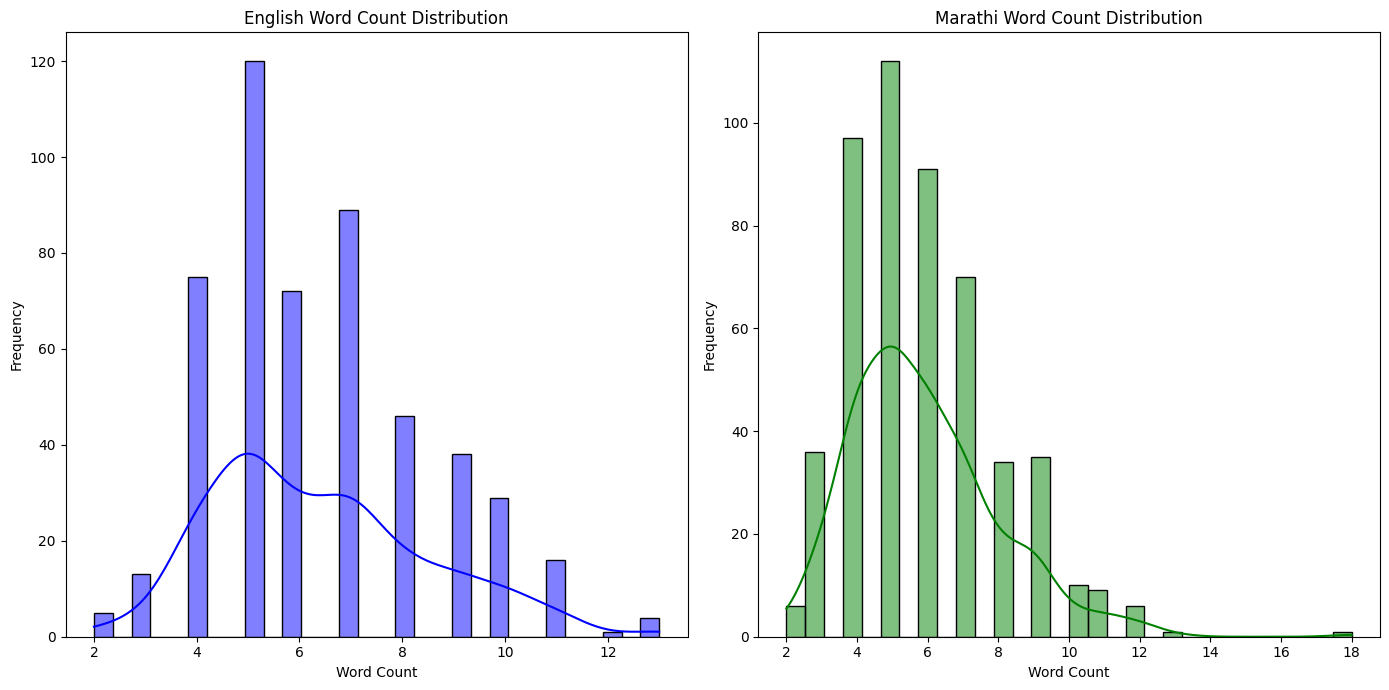

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting area
plt.figure(figsize=(14, 7))

# Plot word count distribution for English
plt.subplot(1, 2, 1)
sns.histplot(train_df['english_word_count'], bins=30, kde=True, color='blue')
plt.title('English Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot word count distribution for Hindi
plt.subplot(1, 2, 2)
sns.histplot(train_df['marathi_word_count'], bins=30, kde=True, color='green')
plt.title('Marathi Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
mar = train_df['Marathi']
eng = train_df['English']
mar = mar.apply(lambda x: "<SOS> " + x + " <EOS>")
eng = eng.apply(lambda x: "<SOS> "+ str(x) + " <EOS>")

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
mar_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
eng_tokenizer.fit_on_texts(eng)
mar_tokenizer.fit_on_texts(mar)
inputs = mar_tokenizer.texts_to_sequences(mar)
targets = eng_tokenizer.texts_to_sequences(eng)

In [ ]:
ENCODER_VOCAB = len(mar_tokenizer.word_index) + 1
DECODER_VOCAB = len(eng_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

1064 755


In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 400

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Custom Loss and Accuracy

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

# Training the Model

In [ ]:
train_loss_history = []
train_accuracy_history = []

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 200 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    train_loss_history.append(train_loss.result())
    train_accuracy_history.append(train_accuracy.result())

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.8172 Accuracy 0.0024
Epoch 1 Loss 6.0273 Accuracy 0.1148
Time taken for 1 epoch: 43.153756618499756 secs

Epoch 2 Batch 0 Loss 5.7380 Accuracy 0.1187
Epoch 2 Loss 5.5274 Accuracy 0.1256
Time taken for 1 epoch: 1.543287992477417 secs

Epoch 3 Batch 0 Loss 5.4941 Accuracy 0.1274
Epoch 3 Loss 5.2764 Accuracy 0.1292
Time taken for 1 epoch: 1.2263507843017578 secs

Epoch 4 Batch 0 Loss 5.3449 Accuracy 0.1303
Epoch 4 Loss 5.1212 Accuracy 0.1311
Time taken for 1 epoch: 1.1550524234771729 secs

Epoch 5 Batch 0 Loss 5.2227 Accuracy 0.1322
Saving checkpoint for epoch 5 at checkpoints/ckpt-1
Epoch 5 Loss 4.9607 Accuracy 0.1389
Time taken for 1 epoch: 1.530855417251587 secs

Epoch 6 Batch 0 Loss 5.2037 Accuracy 0.1401
Epoch 6 Loss 4.8409 Accuracy 0.1467
Time taken for 1 epoch: 1.1355130672454834 secs

Epoch 7 Batch 0 Loss 5.1545 Accuracy 0.1479
Epoch 7 Loss 4.7541 Accuracy 0.1532
Time taken for 1 epoch: 1.136092185974121 secs

Epoch 8 Batch 0 Loss 5.0324 Accuracy 0.1539
Epoc

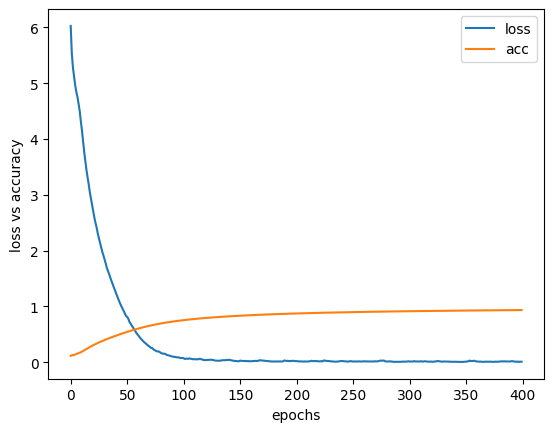

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history,label='loss')
plt.plot(train_accuracy_history,label='acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss vs accuracy')
plt.show()

In [ ]:
def evaluate(text):
    text = mar_tokenizer.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=ENCODER_LEN,
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(text[0], 0)

    decoder_input = [eng_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input,
            output,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == eng_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(hind_text):
    eng_text = evaluate(text=hind_text)[0].numpy()
    eng_text = np.expand_dims(eng_text[1:], 0)
    return eng_tokenizer.sequences_to_texts(eng_text)[0]

# Predictions


In [ ]:
model.translate("हे एक झाड आहे")

'This is a tree'

In [ ]:
r1 = model.translate('प्रकल्प पूर्ण झाला आहे')
r1

'The project is complete'

In [ ]:
model.translate('सूर्य पूर्वेकडून चमकतो')

'The sun shines from the east'

In [ ]:
model.translate('मुंबई ही महाराष्ट्राची राजधानी आहे')

'Mumbai is the capital of Maharashtra'

In [ ]:
model.translate('तुमचा केक स्वादिष्ट आहे')

'Your cake is delicious'

In [ ]:
import numpy as np
actual = np.array(['मुंबई ही महाराष्ट्राची राजधानी आहे','चमकतो','प्रकल्प पूर्ण झाला आहे','खाली वाका!',
                   'उडी मारा','खिडकी बंद करा','मला एक गोष्ट सांगा','त्यांना एका नायकाची गरज आहे',
                   'त्या माझ्यासाठी काम करतात','ते देशद्रोही आहेत','चूक करू नका','त्याची चिंता करू नका',
                   'ते सगळ्यांना आवडलं','सर्वजण धावत बाहेर गेले','तुम्ही चांगले ग्राहक आहात','तू आपली सर्वात चांगली खेळाडू आहेस',
                   'तुम्ही अतिशय धाडसी आहात','तुमचा केक स्वादिष्ट आहे','माझे सर्व मित्र तसं म्हणतात','पोलिसांनी गुन्हेगारांना पकडलं'])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_tokens = []
target_tokens = []

# Iterate over the validation dataset
for inp in actual:
    prediction = model.translate(inp)  # Your method to get the model prediction
    # Flatten the lists and extend the predicted and target tokens
    predicted_tokens.extend(prediction)

In [ ]:
pred = eng_tokenizer.texts_to_sequences(predicted_tokens)

In [ ]:
import numpy as np
from indicnlp.tokenize import indic_tokenize

actual_word_tokens = [indic_tokenize.trivial_tokenize(sentence) for sentence in actual]

# Flatten the list of lists to get a single list of word tokens
actual_word_tokens_flat = [word for sentence in actual_word_tokens for word in sentence]

# Print the tokenized words
print(actual_word_tokens_flat)

['मुंबई', 'ही', 'महाराष्ट्राची', 'राजधानी', 'आहे', 'चमकतो', 'प्रकल्प', 'पूर्ण', 'झाला', 'आहे', 'खाली', 'वाका', '!', 'उडी', 'मारा', 'खिडकी', 'बंद', 'करा', 'मला', 'एक', 'गोष्ट', 'सांगा', 'त्यांना', 'एका', 'नायकाची', 'गरज', 'आहे', 'त्या', 'माझ्यासाठी', 'काम', 'करतात', 'ते', 'देशद्रोही', 'आहेत', 'चूक', 'करू', 'नका', 'त्याची', 'चिंता', 'करू', 'नका', 'ते', 'सगळ्यांना', 'आवडलं', 'सर्वजण', 'धावत', 'बाहेर', 'गेले', 'तुम्ही', 'चांगले', 'ग्राहक', 'आहात', 'तू', 'आपली', 'सर्वात', 'चांगली', 'खेळाडू', 'आहेस', 'तुम्ही', 'अतिशय', 'धाडसी', 'आहात', 'तुमचा', 'केक', 'स्वादिष्ट', 'आहे', 'माझे', 'सर्व', 'मित्र', 'तसं', 'म्हणतात', 'पोलिसांनी', 'गुन्हेगारांना', 'पकडलं']


In [ ]:
act = mar_tokenizer.texts_to_sequences(actual_word_tokens_flat)

In [ ]:
predicted_sentences = [
    'Mumbai is the capital of Maharashtra',
    'Shines',
    'The project is complete',
    'Bend down!',
    'Jump',
    'Close the window',
    'Tell me one thing',
    'They need a hero',
    'They work for me',
    'They are traitors',
    'Do not make a mistake',
    'Do not worry about it',
    'Everyone liked it',
    'Everyone ran out',
    'You are a good customer',
    'You are our best player',
    'You are very brave',
    'Your cake is delicious',
    'All my friends say so',
    'Police caught the criminals'
]

# Convert predicted sentences to word tokens
predicted_word_tokens = [sentence.split() for sentence in predicted_sentences]
predicted_word_tokens_flat = [word for sentence in predicted_word_tokens for word in sentence]

<Figure size 1000x1000 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2326 (\N{DEVANAGARI LETTER KHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/I

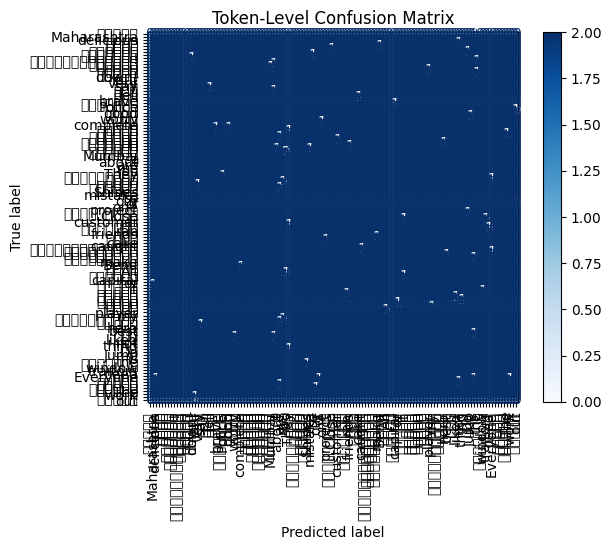

In [ ]:
import matplotlib.pyplot as plt
#To handle different lengths, we match the shortest length between actual and predicted
min_length = min(len(actual_word_tokens_flat), len(predicted_word_tokens_flat))
actual_tokens_flat = actual_word_tokens_flat[:min_length]
predicted_tokens_flat = predicted_word_tokens_flat[:min_length]

# Map each token to an integer label
unique_tokens = list(set(actual_tokens_flat + predicted_tokens_flat))
token_to_int = {token: i for i, token in enumerate(unique_tokens)}

actual_ints = [token_to_int[token] for token in actual_tokens_flat]
predicted_ints = [token_to_int[token] for token in predicted_tokens_flat]

# Compute the confusion matrix
conf_matrix = confusion_matrix(actual_ints, predicted_ints)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_tokens)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Token-Level Confusion Matrix')
plt.show()

In [ ]:
act_predicted_word_tokens = [sentence.split() for sentence in predicted_sentences]
act_predicted_word_tokens_flat = [word for sentence in predicted_word_tokens for word in sentence]

In [ ]:
pre = eng_tokenizer.texts_to_sequences(predicted_word_tokens_flat)

***BLEU SCORE***

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from indicnlp.tokenize import indic_tokenize

smoothing_function = SmoothingFunction().method1
bleu_scores = [sentence_bleu([ref], pred, smoothing_function=smoothing_function)
               for ref, pred in zip(act_predicted_word_tokens, predicted_word_tokens)]

In [ ]:
bleu_scores

[1.0,
 0.1778279410038923,
 1.0,
 0.316227766016838,
 0.1778279410038923,
 0.5623413251903491,
 1.0,
 1.0,
 1.0,
 0.5623413251903491,
 1.0,
 1.0,
 0.5623413251903491,
 0.5623413251903491,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]